# Fullscan Renders
Outputting the graphs of the data collected by running the robot :) This notebook is for viewing the fullscan data, as well as trying to reproduce a mathematical model of the relationship between the transducer pulser and it's position/rotation.

### Import relevant modules

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline
# %matplotlib widget
# %pylab

from fit_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check for available files

In [142]:
path = os.path.abspath('..\\')
print("Available test files:")

## Uncomment this to access immersion transducer scans
# file_itr = 0
# while os.path.exists(path + "\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr):
#     print("\t\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr)
#     file_itr +=1

file_itr = 0
while os.path.exists(path + "\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr):
    print("\t\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr)
    file_itr +=1


Available test files:
	\Scans\OCE_Scans\oce_test_0.json
	\Scans\OCE_Scans\oce_test_1.json
	\Scans\OCE_Scans\oce_test_2.json
	\Scans\OCE_Scans\oce_test_3.json
	\Scans\OCE_Scans\oce_test_4.json
	\Scans\OCE_Scans\oce_test_5.json
	\Scans\OCE_Scans\oce_test_6.json
	\Scans\OCE_Scans\oce_test_7.json
	\Scans\OCE_Scans\oce_test_8.json


### Select appropriate file and output options
Debug mode prints more information to the notebook, save_figs outputs the relevant figures to a designated folder, and file_no specifices which scan file should be used.

In [143]:
debug_mode = True
save_figs = False
file_no = 6

# plt.style.use("dark_background")
plt.style.use("default")

if save_figs:
    plt.rcParams['figure.dpi'] = 400
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
else:
    plt.rcParams['figure.dpi'] = 250

In [144]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = rf"\Scans\OCE_Scans\oce_test_{file_no}.json"
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

print(json_data.keys())

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
points = json_data["points"]
max_point = json_data["max_point"]

if 'data_channels' in json_data.keys():
    num_channels = json_data['data_channels']
    data_labels = ['flatness', 'sharpness']
else:
    num_channels = 1

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
        else:
            print(f"{i}: {json_data[i][0]}")


c:\Users\ander\Documents\COBOT-Transducer-Control-Code\Scans\OCE_Scans\oce_test_6.json
dict_keys(['range of motion', 'data_channels', 'resolution', 'max_point', 'points', 'notes', 'active_ROM'])
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-5, 5], 'Rx': [-10, 10], 'Ry': [-10, 10], 'Rz': [0, 0]}
data_channels: 2
resolution: [0.2, 1]
max_point: [0.0, 0.0, 2.4000000000000004, 7.0, 4.0, 0.0, 0.98938, 0.0001]
points: [-0.7999999999999998, -4.0, -9.0, 0.93103, 0.00166]
notes: No notes passed from setup.
Ellipsoidal version of a fullscan module, scans an n-ellipse around the origin at a fixed resolution.
	Range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-5, 5], 'Rx': [-10, 10], 'Ry': [-10, 10], 'Rz': [0, 0]}
	Resolution: (0.2, 1)
	Highest magnitude found: [ 0.00  0.00  2.40  7.00  4.00  0.00  0.99  0.00]
active_ROM: ['Z', 'Rx', 'Ry']


### Parse data into a pandas DataFrame

In [145]:
np_all = np.array(points)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
for i in range(num_channels):
    cols.append(data_labels[i])
dat = pd.DataFrame(data = np_all, columns=cols)

mp = dat.loc[dat[data_labels[0]].idxmax()]

if debug_mode:
    print(mp)
    print(dat.head())
    print(dat.shape)

Z            2.40000
Rx           7.00000
Ry           4.00000
flatness     0.98938
sharpness    0.00010
Name: 8445, dtype: float64
     Z   Rx   Ry  flatness  sharpness
0 -0.8 -4.0 -9.0   0.93103    0.00166
1 -0.6 -4.0 -9.0   0.80129    0.00000
2 -0.4 -4.0 -9.0   0.88639    0.00000
3 -0.2 -4.0 -9.0   0.78132    0.00000
4  0.0 -4.0 -9.0   0.81801    0.00000
(10398, 5)


### First Figure, all data

0.16074
37870
51990
Maximum magnitude:  0.98938
Minimum magnitude: -3.10055
Median magnitude: 0.16074
0.98938
0.00012
32655
51990
Maximum magnitude:  0.99994
Minimum magnitude: -1.0
Median magnitude: 0.00012
0.99994


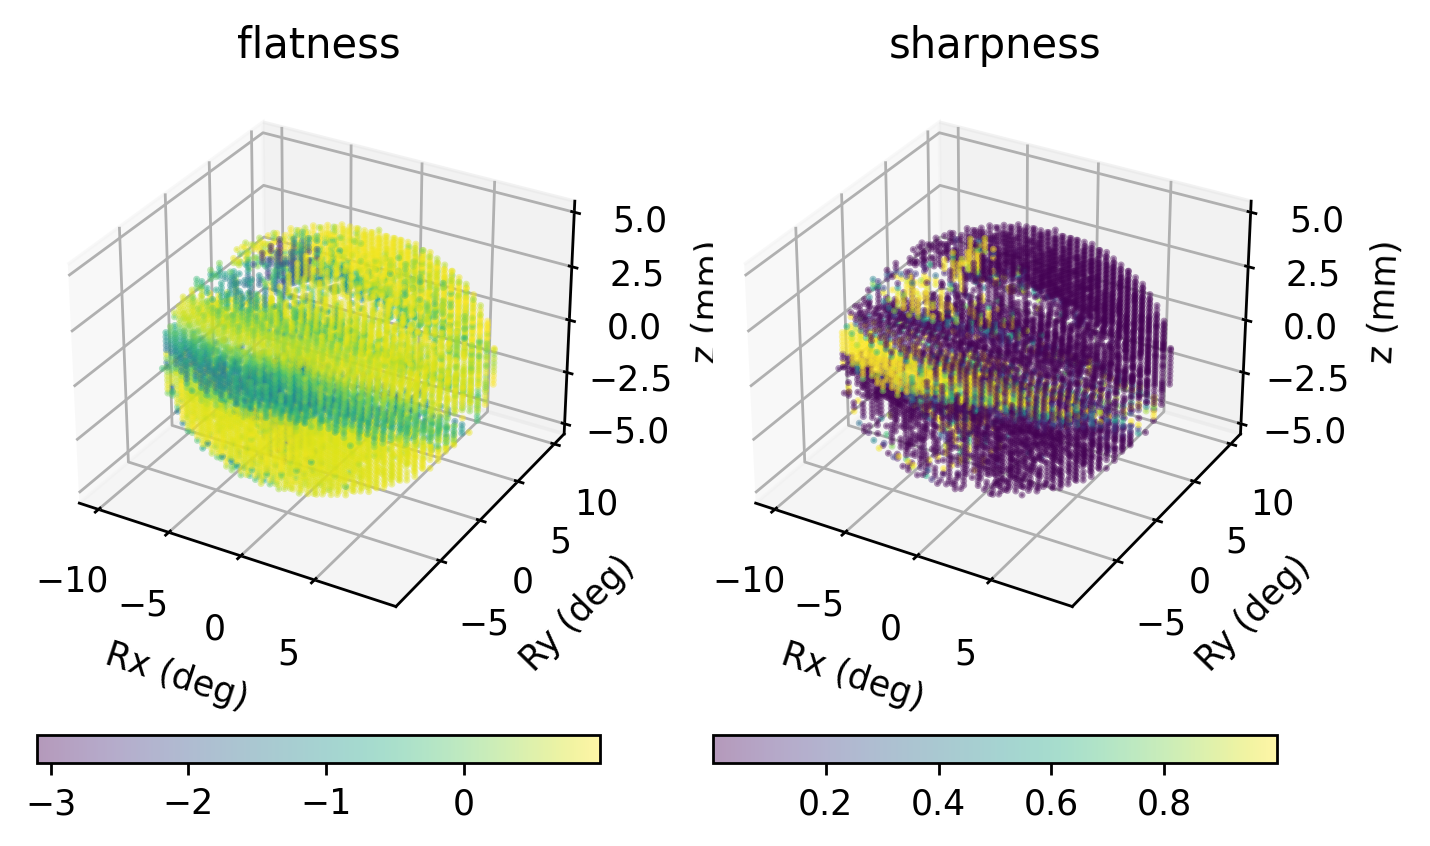

In [146]:
fig = plt.figure()

for i in range(num_channels):
    ax = fig.add_subplot(1,num_channels,i+1,projection='3d')
    # ax = plt.axes(projection='3d')
    data_col = data_labels[i]

    med = np.median(dat[data_col])
    dat2 = dat[dat[data_col] != -1]
    dat2 = dat2[dat2[data_col] != 0]

    print(med)
    print(dat2.size)
    print(dat.size)

    cmap = plt.cm.viridis # Choose colormap
    my_cmap = cmap(np.arange(cmap.N)) # Get the colormap colors
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)*0.8 # Set alpha
    my_cmap = ListedColormap(my_cmap) # Create new colormap

    scatterplot = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2[data_col], cmap='viridis', alpha=0.4,s=1)
    # ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap=my_cmap,s=4)
    # ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap='viridis',s=1,alpha=0.2)

    plt.colorbar(scatterplot, orientation='horizontal', pad=0.1)

    ax.set_title(f"{data_col}")
    ax.set_xlabel("Rx (deg)")
    ax.set_ylabel("Ry (deg)")
    ax.set_zlabel("z (mm)")

    if save_figs:
        plt.savefig("figures\\fullscan_render_test_%s.jpg" % file_no)
        pass
    
    # plt.show()

    if debug_mode:
        print(f"Maximum magnitude:  {max(dat[data_col])}")
        print(f"Minimum magnitude: {min(dat[data_col])}")
        print(f"Median magnitude: {med}")
        print(max(dat[data_col]))
    
        # print((min(dat2['Rx']),max(dat2['Rx'])))
        # print((min(dat2['Ry']),max(dat2['Ry'])))
        # print((min(dat2['Z']),max(dat2['Z'])))

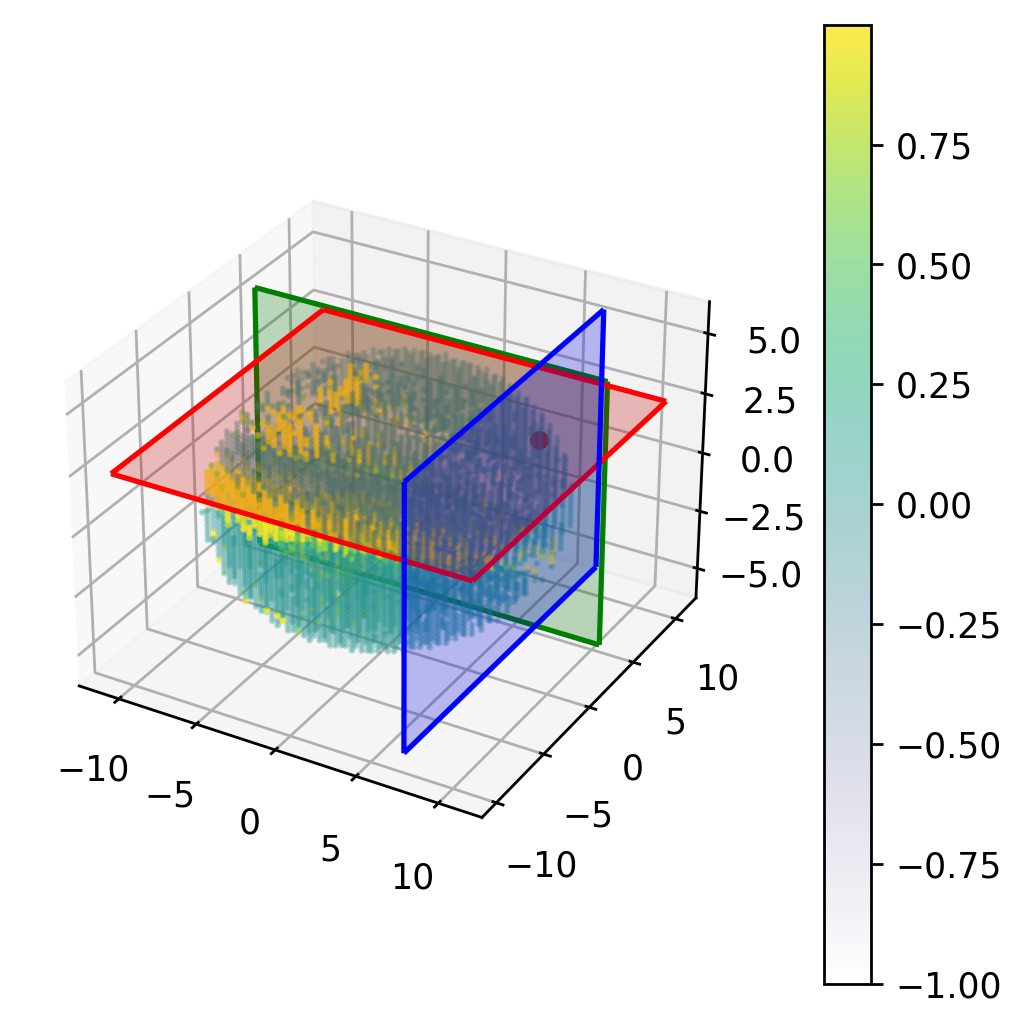

In [147]:
fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap=my_cmap,s=1)
ax.scatter(mp['Rx'], mp['Ry'], mp['Z'], color='r')
plt.colorbar(scatter)

alpha = 0.25
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

X,Y = np.meshgrid(xlim,ylim)
Z = np.ones(X.shape)*mp['Z']
ax.plot_surface(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r')

# Slice through the Rx-Z plane with maximum Ry
X,Z = np.meshgrid(xlim,zlim)
Y = np.ones(Y.shape)*mp['Ry']
ax.plot_surface(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g')

# Slice through the Rx-Ry plane with maximum Z
Z,Y = np.meshgrid(zlim,ylim)
X = np.ones(X.shape)*mp['Rx']
ax.plot_surface(X=X, Y=Y, Z=Z, color='b', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b')

# plt.savefig("figures\\data_slice1_%s.jpg" % file_no, dpi=400)

In [148]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']]
Rxmps = dat[dat['Rx'] == mp['Rx']]
Rymps = dat[dat['Ry'] == mp['Ry']]
med = np.median(dat[data_labels[0]])

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of point/mags array: {np_all.shape}")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

# foo_isolated_mps refers to the points along the isolated foo axis when the other axes are at their optimal values
z_isolated_mps = dat[np.all([dat['Rx'] == mp['Rx'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
Rx_isolated_mps = dat[np.all([dat['Z'] == mp['Z'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
Ry_isolated_mps = dat[np.all([dat['Z'] == mp['Z'], dat['Rx'] == mp['Rx']],axis=0)].reset_index(drop=True)

if debug_mode:
    print(Ry_isolated_mps.head())
    # print(Rx_isolated_mps)
    # print(Ry_isolated_mps)
    pass

Active range of motion: ['Z', 'Rx', 'Ry']
Shape of point/mags array: (10398, 5)
Tenth point_mag item (representative): [-1.2     -3.      -9.       0.81782  0.     ]
Testing the Z-max-points array:
       Z   Rx   Ry  flatness  sharpness
214  2.4 -3.0 -8.0  -0.01935    0.06914
241  2.4 -2.0 -8.0   0.08651    0.03917
270  2.4 -1.0 -8.0   0.12403    0.00995
300  2.4  0.0 -8.0   0.18756    0.00166
(Should be all the same as in the maxpoint)
Maximum point: Z            2.40000
Rx           7.00000
Ry           4.00000
flatness     0.98938
sharpness    0.00010
Name: 8445, dtype: float64
     Z   Rx   Ry  flatness  sharpness
0  2.4  7.0 -5.0   0.65379    0.00010
1  2.4  7.0 -4.0   0.63693    0.00034
2  2.4  7.0 -3.0   0.85194    0.00018
3  2.4  7.0 -2.0   0.82990    0.00018
4  2.4  7.0 -1.0   0.86090    0.00034


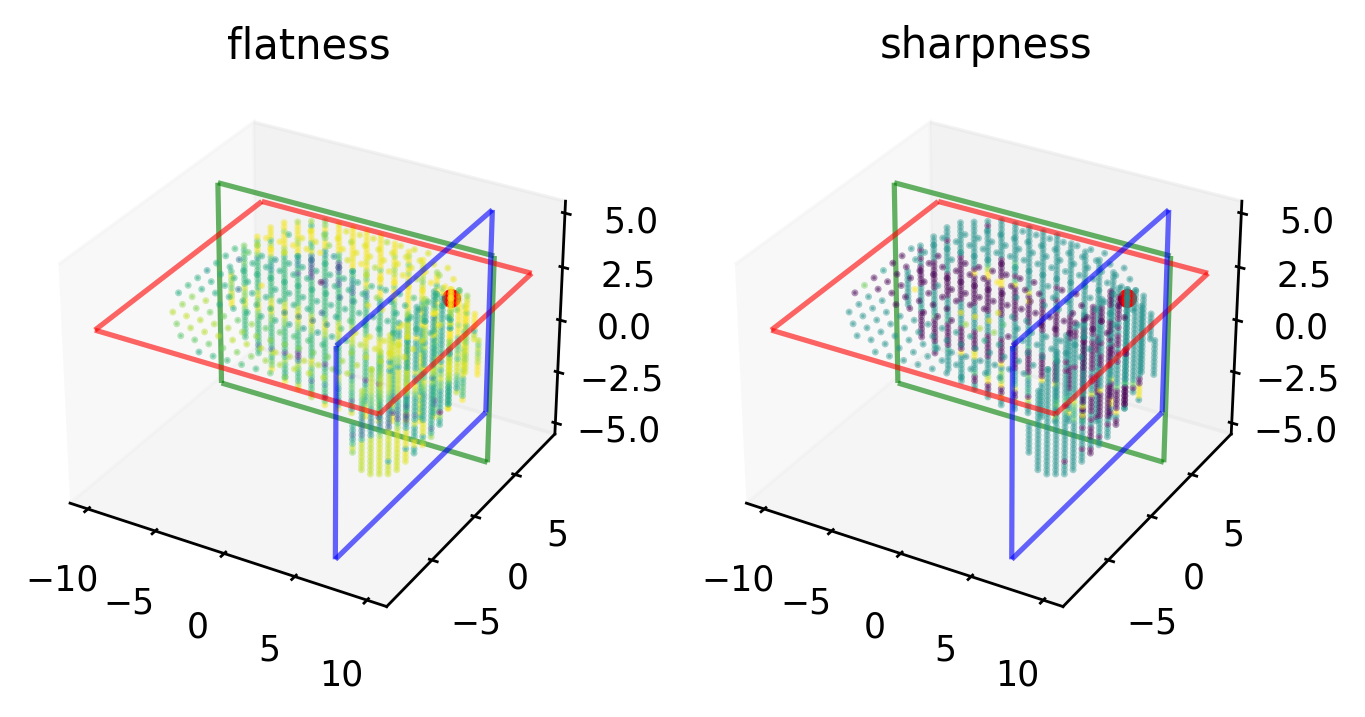

In [149]:
fig = plt.figure()
for i in range(num_channels):
    ax = fig.add_subplot(1,num_channels, i+1,projection='3d')

    data_col = data_labels[i]
    # ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2[data_col], cmap='viridis', alpha=0.2,s=1)
    # ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap='viridis', alpha=0.005)#,s=9)
    ax.scatter(zmps['Rx'], zmps['Ry'], np.ones(zmps['Ry'].shape)* mp['Z'], c=zmps[data_col], cmap='viridis', alpha=0.4,s=1)
    ax.scatter(np.ones(Rxmps['Ry'].shape)* mp['Rx'], Rxmps['Ry'], Rxmps['Z'], c=Rxmps[data_col], cmap='viridis', alpha=0.4,s=1)
    ax.scatter(Rymps['Rx'], np.ones(Rymps['Ry'].shape)* mp['Ry'], Rymps['Z'], c=Rymps[data_col], cmap='viridis', alpha=0.4,s=1)
    ax.scatter(mp['Rx'], mp['Ry'], mp['Z'], color='r')
    ax.set_title(f"{data_col}")
    # tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps[data_col],c=zmps[data_col], cmap='viridis',s=4)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.grid(False)
    # ax.xaxis.pane.set_visible(False)
    # ax.yaxis.pane.set_visible(False)
    # ax.zaxis.pane.set_visible(False)

    alpha = 0.6
    # Slice through the Rx-Ry plane with maximum Z
    X,Y = np.meshgrid(xlim,ylim)
    Z = np.ones(X.shape)*mp['Z']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
    # Slice through the Rx-Z plane with maximum Ry
    X,Z = np.meshgrid(xlim,zlim)
    Y = np.ones(X.shape)*mp['Ry']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
    # Slice through the Rx-Ry plane with maximum Z
    Z,Y = np.meshgrid(zlim,ylim)
    X = np.ones(X.shape)*mp['Rx']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b', alpha=alpha)

if save_figs:
    plt.savefig("figures\\data_slice2_%s.jpg" % file_no)

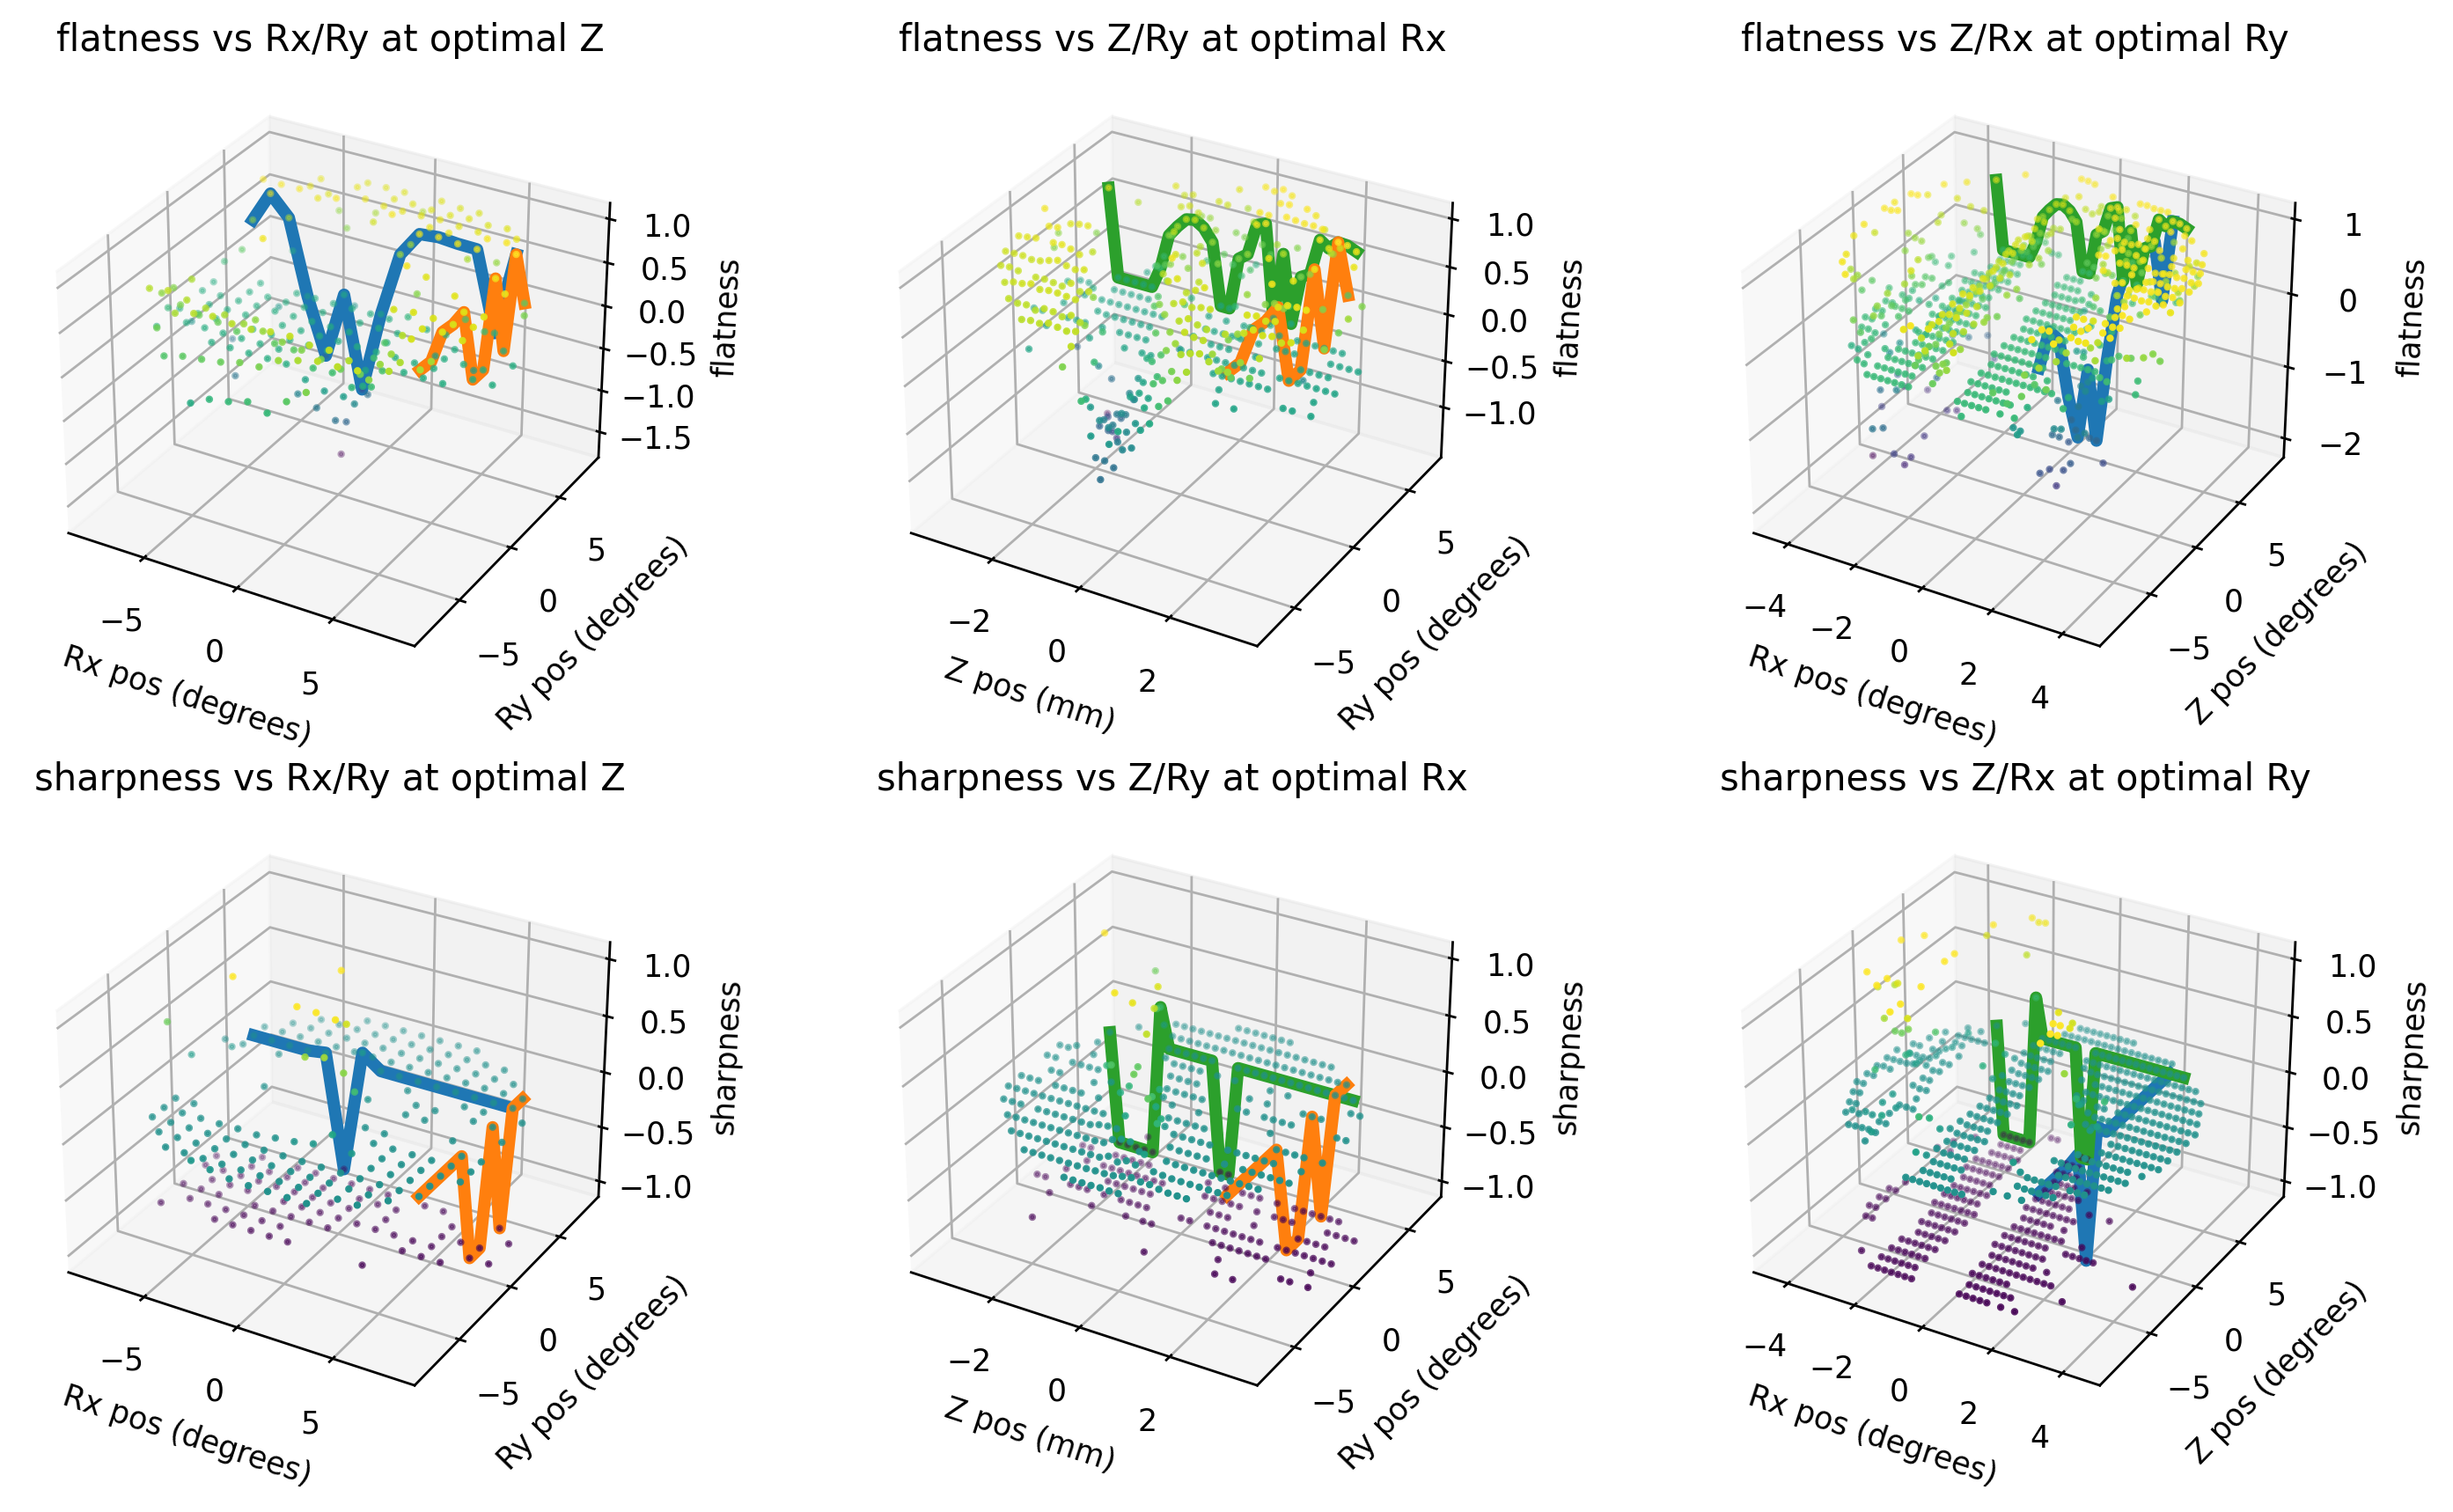

In [150]:
fig2 = plt.figure(figsize=(14,4*num_channels))
# tax = plt.figure()
# tax = plt.axes(projection="3d")
for i in range(num_channels):
    lw = 4
    data_col = data_labels[i]
    tax = fig2.add_subplot(num_channels,3,1+(3*i), projection='3d')
    # tax = plt.axes(projection='3d')
    tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps[data_col],c=zmps[data_col], cmap='viridis',s=2)
    tax.plot3D(Rx_isolated_mps['Rx'], Rx_isolated_mps['Ry'], Rx_isolated_mps[data_col], c='C0', linewidth=lw)
    tax.plot3D(Ry_isolated_mps['Rx'], Ry_isolated_mps['Ry'], Ry_isolated_mps[data_col], c='C1', linewidth=lw)
    tax.set_title(f"{data_col} vs Rx/Ry at optimal Z")
    tax.set_xlabel("Rx pos (degrees)")
    tax.set_ylabel("Ry pos (degrees)")
    tax.set_zlabel(f"{data_col}")
    # tax.grid(False)
    # ax.xaxis.pane.set_visible(False)
    # ax.yaxis.pane.set_visible(False)
    # ax.zaxis.pane.set_visible(False)

    tax = fig2.add_subplot(num_channels,3,2+(3*i), projection='3d')
    tax.scatter(Rxmps['Z'], Rxmps['Ry'], Rxmps[data_col],c=Rxmps[data_col], cmap='viridis',s=2)
    tax.plot3D(z_isolated_mps['Z'], z_isolated_mps['Ry'], z_isolated_mps[data_col],c='C2', linewidth=lw)
    tax.plot3D(Ry_isolated_mps['Z'], Ry_isolated_mps['Ry'], Ry_isolated_mps[data_col],c='C1', linewidth=lw)
    tax.set_title(f"{data_col} vs Z/Ry at optimal Rx")
    tax.set_xlabel("Z pos (mm)")
    tax.set_ylabel("Ry pos (degrees)")
    tax.set_zlabel(f"{data_col}")

    tax = fig2.add_subplot(num_channels,3,3+(3*i), projection='3d')
    # tax.plot_trisurf(Rymps[:,0], Rymps[:,1], Rymps[:,3], cmap='viridis')
    tax.scatter(Rymps['Z'], Rymps['Rx'], Rymps[data_col],c=Rymps[data_col], cmap='viridis',s=2)
    tax.plot(Rx_isolated_mps['Z'], Rx_isolated_mps['Rx'], Rx_isolated_mps[data_col],c='C0', linewidth=lw)
    tax.plot(z_isolated_mps['Z'], z_isolated_mps['Rx'], z_isolated_mps[data_col],c='C2', linewidth=lw)
    tax.set_title(f"{data_col} vs Z/Rx at optimal Ry")
    tax.set_ylabel("Z pos (degrees)")
    tax.set_xlabel("Rx pos (degrees)")
    tax.set_zlabel(f"{data_col}")

if save_figs:
    plt.savefig("figures\\Isolated_axes_w_trace_%s.jpg" % file_no)
plt.show()

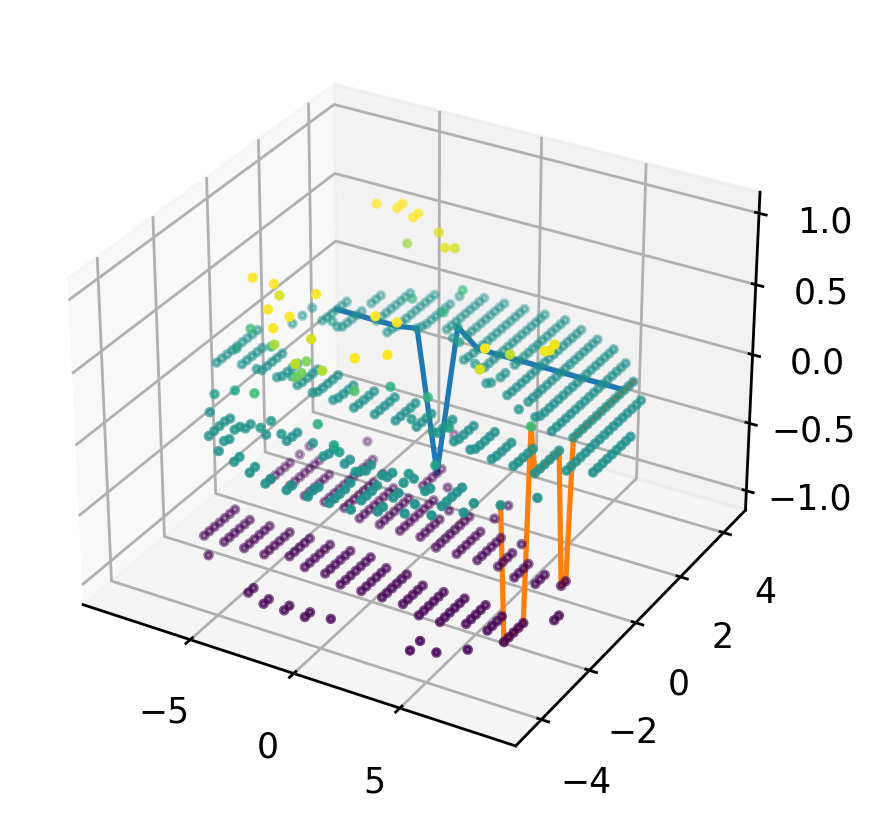

In [151]:
fig2 = plt.figure(figsize=(4,4), constrained_layout=False)
tax = fig2.add_subplot(projection='3d')
data_col = data_labels[1]

# tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps[data_col],c=zmps[data_col], cmap='viridis',s=4)
# tax.plot3D(Rx_isolated_mps['Rx'], Rx_isolated_mps['Ry'], Rx_isolated_mps[data_col],c='C0')
# tax.plot3D(Ry_isolated_mps['Rx'], Ry_isolated_mps['Ry'], Ry_isolated_mps[data_col],c='C1')
# tax.set_title("magnitude vs Rx/Ry at optimal Z")
# tax.set_xlabel("Rx pos (degrees)")
# tax.set_ylabel("Ry pos (degrees)")
# tax.set_zlabel("Signal magnitude (mV)")

# tax.scatter3D(Rxmps['Z'], Rxmps['Ry'], Rxmps[data_col],c=Rxmps[data_col], cmap='viridis',s=4)
# tax.plot3D(z_isolated_mps['Z'], z_isolated_mps['Ry'], z_isolated_mps[data_col],c='C0')
# tax.plot3D(Ry_isolated_mps['Z'], Ry_isolated_mps['Ry'], Ry_isolated_mps[data_col],c='C1')

tax.scatter(Rymps['Rx'], Rymps['Z'], Rymps[data_col],c=Rymps[data_col], cmap='viridis',s=4)
tax.plot(Rx_isolated_mps['Rx'], Rx_isolated_mps['Z'], Rx_isolated_mps[data_col],c='C0')
tax.plot(z_isolated_mps['Rx'], z_isolated_mps['Z'], z_isolated_mps[data_col],c='C1')

if save_figs:
    plt.savefig("figures\\Isolated_axes_1_%s.jpg" % file_no)

Guess: [800, 0.1, 1, 4.0, 2.4000000000000004, 0.16074]
Fin: [-7.6876, 0.1152, 8.8985, 1.2396, 2.8001, 0.5151]
R2: 0.25909553089373705


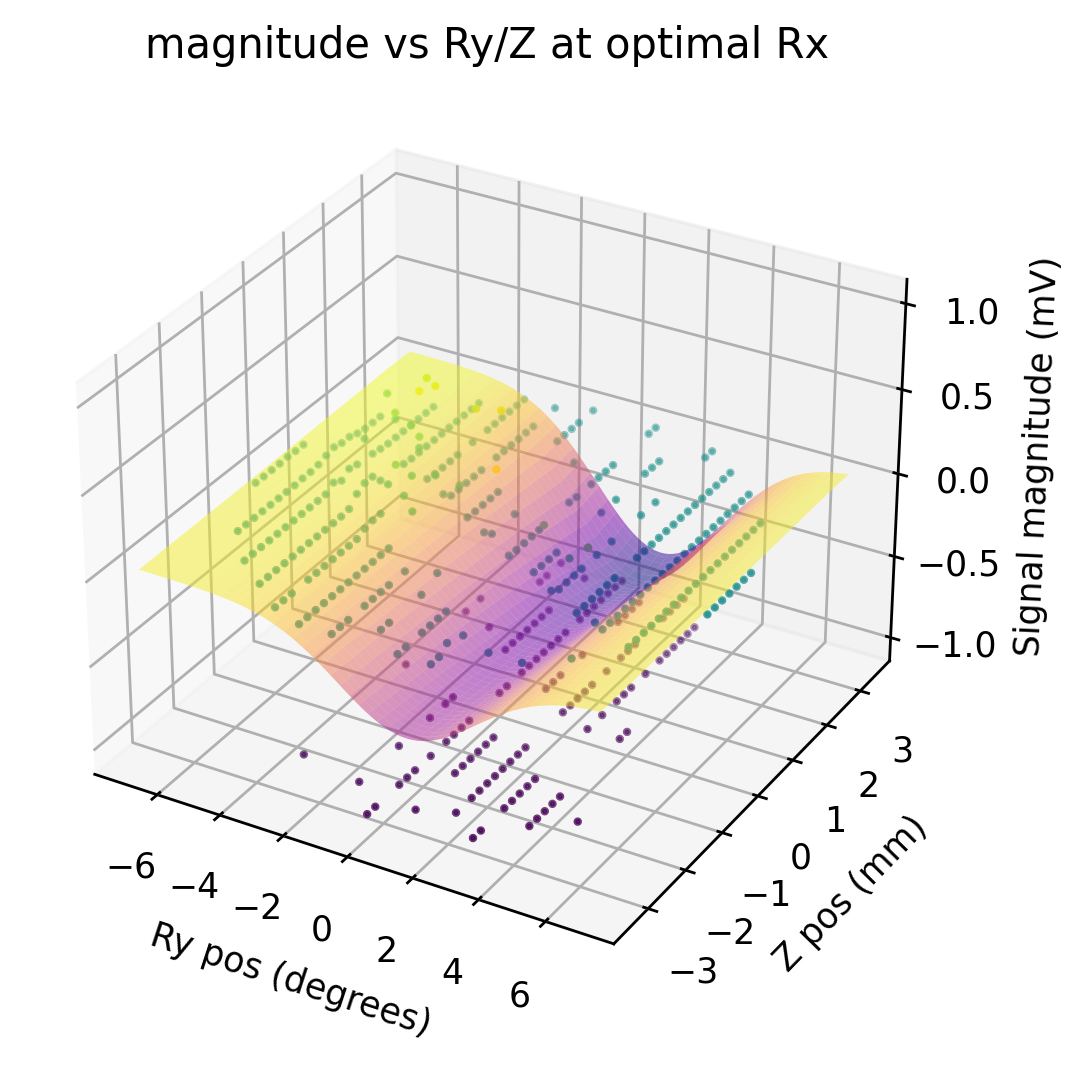

In [152]:
# (X,Y,Z,title,xlable,ylable,guess) = (zmps['Rx'],zmps['Ry'],zmps[data_col],"magnitude vs Ry/Rx at optimal Z","Rx pos (degrees)","Ry pos (degrees)",[600,60,mp['Rx'],mp['Ry'],med])
(X,Y,Z,title,xlable,ylable,guess) = (Rxmps['Ry'],Rxmps['Z'],Rxmps[data_col],"magnitude vs Ry/Z at optimal Rx","Ry pos (degrees)","Z pos (mm)",[800,0.1,1,mp['Ry'],mp['Z'],med])
# (X,Y,Z,title,xlable,ylable,guess) = (Rymps['Ry'],Rymps['Z'],Rymps[data_col],"magnitude vs Rx/Z at optimal Ry","Z pos (mm)","Rx pos (degrees)",[1,1,1,1,mp['Z'],mp['Ry'],med])

popt, pcov = curve_fit(ang_plus_z, [X, Y], Z,p0=guess,maxfev=5000)
# popt, pcov = curve_fit(double_ang,[X,Y],Z)
# print(popt)
print(f"Guess: {guess}")
# popt, pcov = curve_fit(double_ang,[X,Y],Z,p0=guess)
print(f"Fin: {[round(i,4) for i in popt]}")
print(f"R2: {r_squared(ang_plus_z, popt, [X, Y], Z)}")


# create surface function model
# setup data points for calculating surface model
model_y_data = np.linspace(min(Y), max(Y), 100)
model_x_data = np.linspace(min(X), max(X), 100)
# create coordinate arrays for vectorized evaluations
Xs, Ys = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
Zs = ang_plus_z(np.array([Xs, Ys]), *popt)


fig3 = plt.figure()

tax = plt.axes(projection="3d")
# tax = fig3.add_subplot(1,2,1, projection='3d')

tax.scatter3D(X,Y,Z,cmap='viridis',c=Z,s=2)
tax.set_title(title)
tax.set_xlabel(xlable)
tax.set_ylabel(ylable)
tax.set_zlabel("Signal magnitude (mV)")
# tax.axis("off")
tax.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# tax.view_init(0,0)

# tax2 = fig3.add_subplot(1,2,2, projection='3d')

# tax2.scatter3D(X,Y,Z,cmap='viridis',c=Z,s=2)
# # tax2.set_title(title)
# # tax.set_xlabel(xlable)
# # tax.set_ylabel(ylable)
# # tax.set_zlabel("Signal magnitude (mV)")
# tax2.axis("off")
# tax2.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# # tax2.view_init(0,90)


if save_figs:
    tax.get_figure().savefig("figures\\Fullscan_2d_fit_%s.jpg" % file_no)

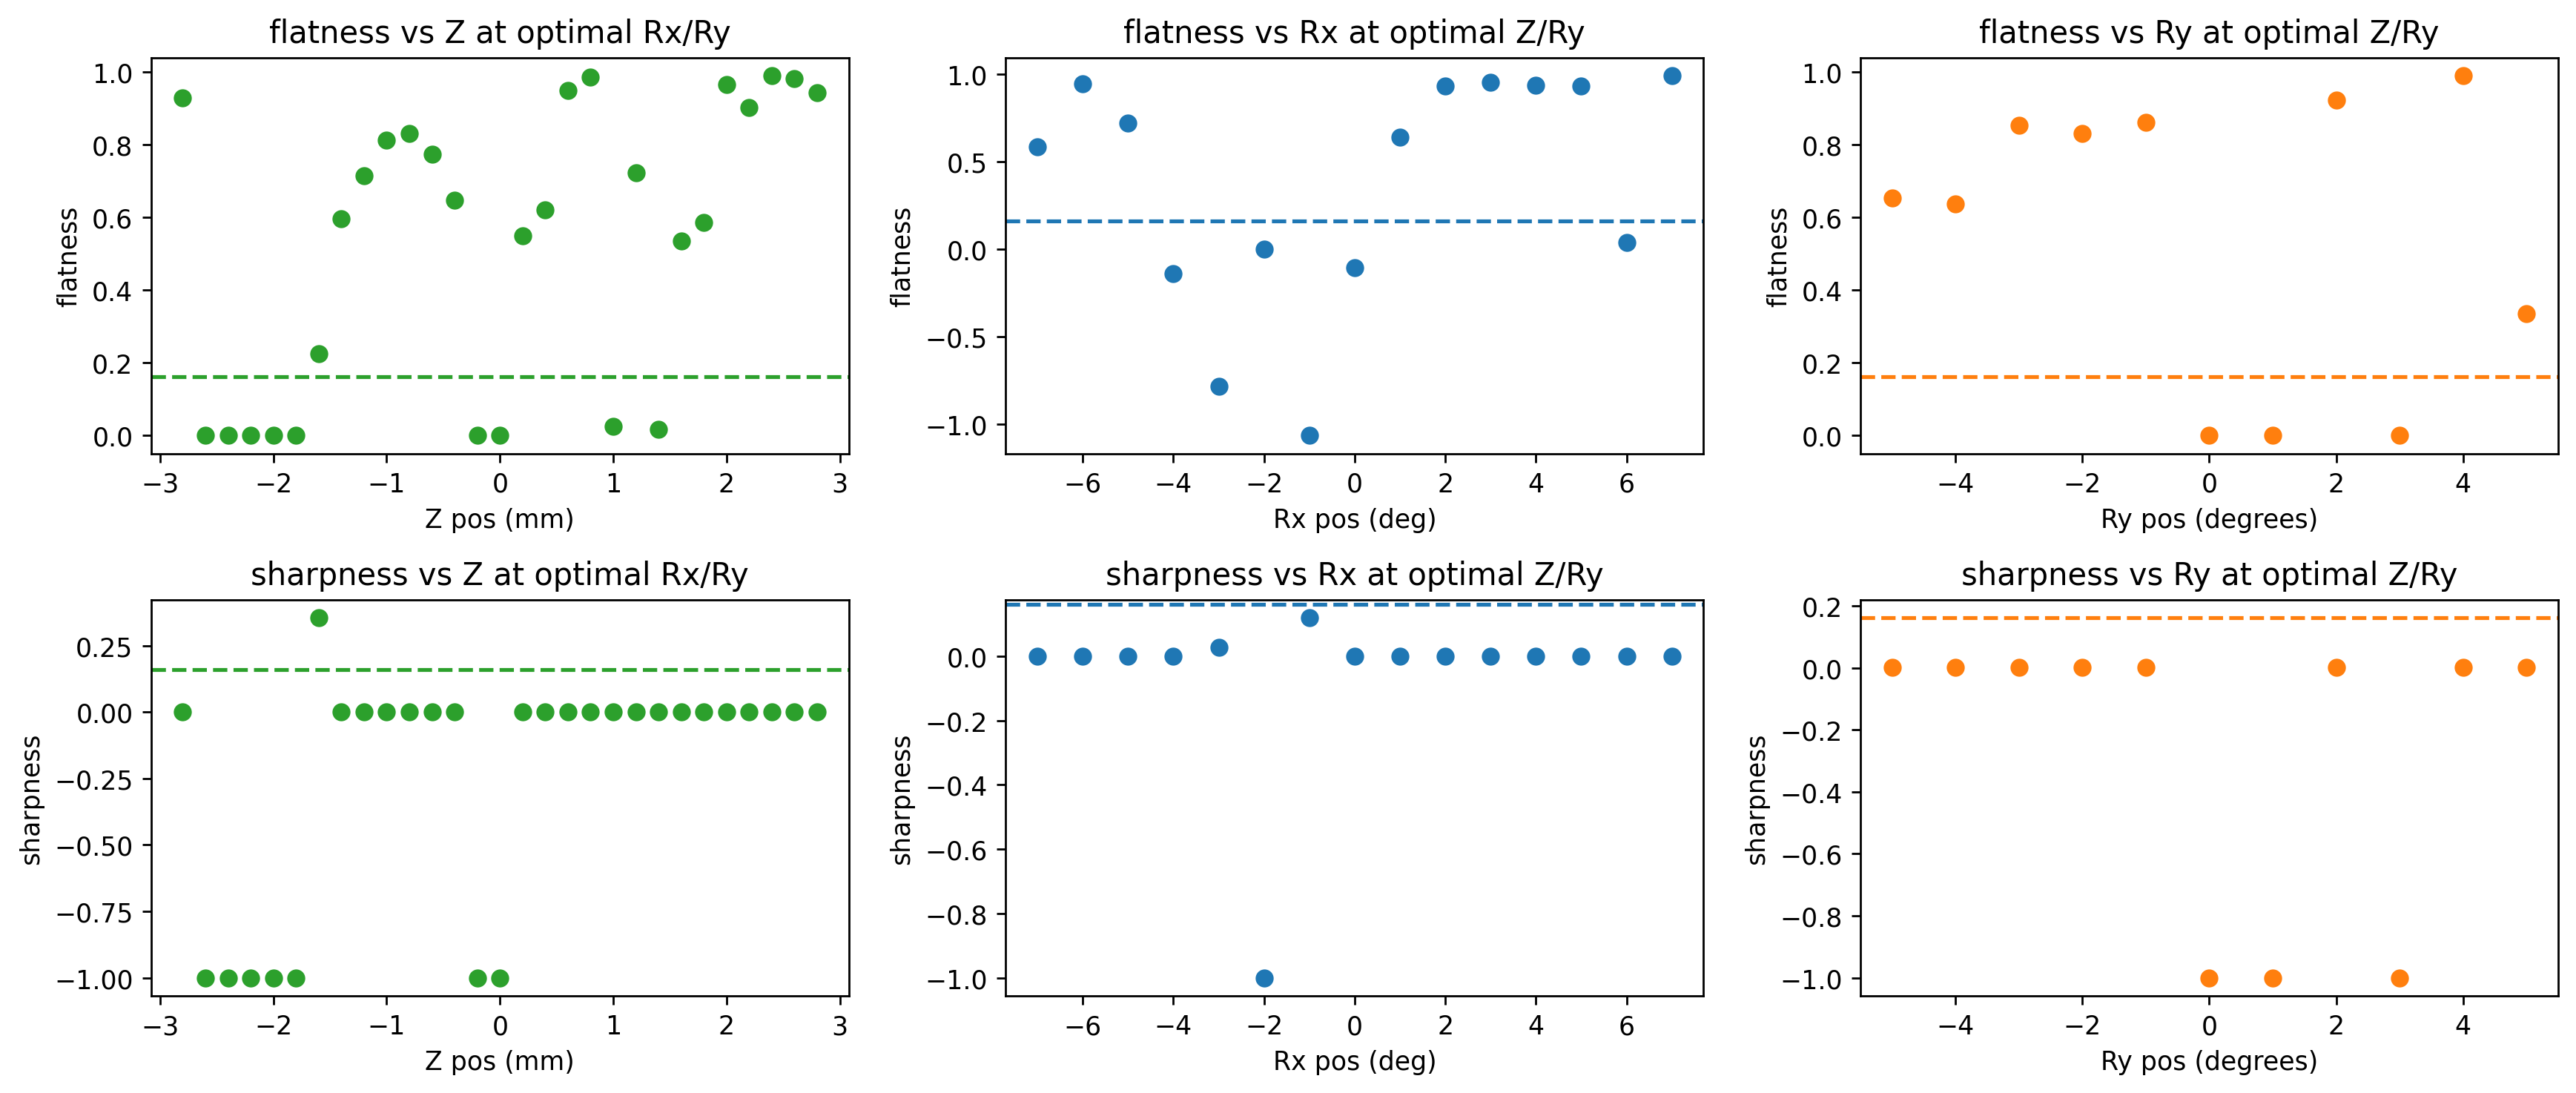

In [153]:
fig3 = plt.figure(figsize=(14,3*num_channels))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)
for i in range(num_channels):
    data_col = data_labels[i]
    tax = fig3.add_subplot(num_channels,3,1+(3*i))
    tax.scatter(z_isolated_mps['Z'],z_isolated_mps[data_col], c='C2')
    tax.axhline(med, c='C2',ls='--')
    # tax.axhline(np.median(dat[data_col]), c='r',ls='--')
    tax.set_title(f"{data_col} vs Z at optimal Rx/Ry")
    tax.set_xlabel("Z pos (mm)")
    tax.set_ylabel(data_col)

    tax = fig3.add_subplot(num_channels,3,2+(3*i))
    tax.scatter(Rx_isolated_mps['Rx'],Rx_isolated_mps[data_col], c='C0')
    tax.axhline(med, c='C0',ls='--')
    tax.set_title(f"{data_col} vs Rx at optimal Z/Ry") 
    tax.set_xlabel("Rx pos (deg)")
    tax.set_ylabel(data_col)

    tax = fig3.add_subplot(num_channels,3,3+(3*i))
    tax.scatter(Ry_isolated_mps['Ry'],Ry_isolated_mps[data_col], c='C1')
    tax.axhline(med, c='C1',ls='--')
    tax.set_title(f"{data_col} vs Ry at optimal Z/Ry")
    tax.set_xlabel("Ry pos (degrees)")
    tax.set_ylabel(data_col)

fig3.tight_layout()

if save_figs:
    plt.savefig("figures\\Single-axis magnitude plots%s.jpg" % file_no)

KeyError: '[70] not in index'

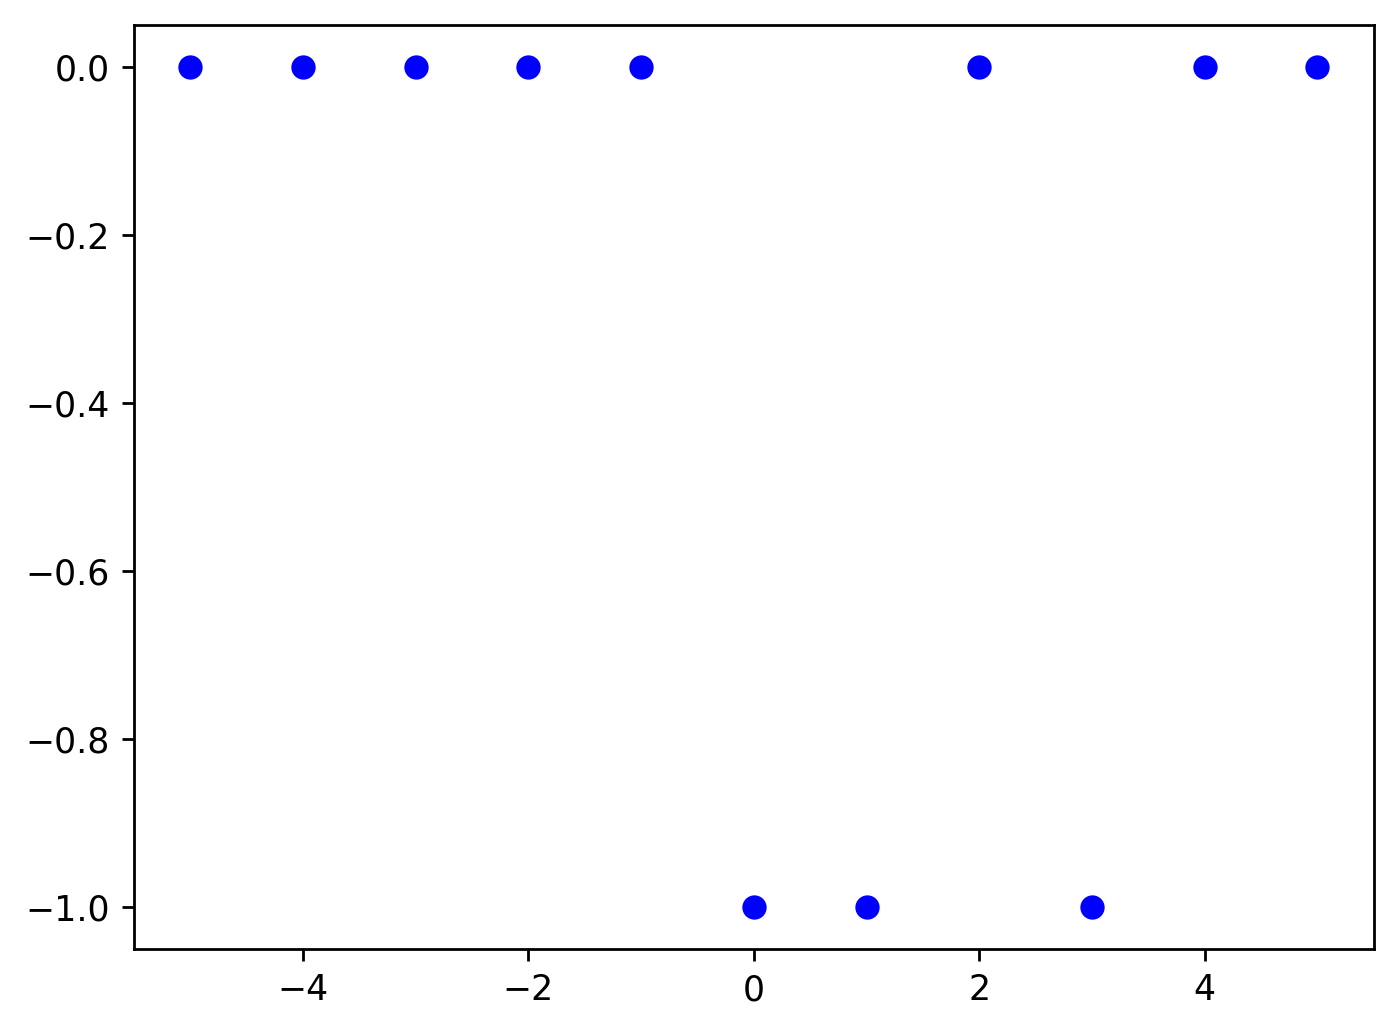

In [154]:
fig4 = plt.axes()
fig4.get_figure()

interpolation_windows= { \
    "Z": [0,0], \
    "Rx": [0,0], \
    "Ry": [0,70]}
# interpolation_windows= { \
#     "Z": [8,56], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}
# interpolation_windows= { \
#     "Z": [8,40], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}

t = {'Z': {'data': z_isolated_mps, 'color1': 'r', 'noise': med, 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'Rx': {'data': Rx_isolated_mps, 'color1': 'g', 'noise': med, 'color2':'b', \
    'header':'magnitude vs Rx at optimal Z/Ry', 'x-axis': "Rx ang (deg)"}, \
    'Ry': {'data': Ry_isolated_mps, 'color1':'b', 'noise': med, 'color2':'r', \
    'header':'magnitude vs Ry at optimal Z/Rx', 'x-axis':"Ry ang (deg)"}}

b = 'Ry'
a = interpolation_windows[b]

funcs = [(polynomial_2,[1,1,1]),
        (rational_2,[1,1,1,1]),
        (inv_absolute,[1,1,mp[b],med]),
        (gauss,[1,1,mp[b],med])]


fig4.scatter(t[b]['data'][b],t[b]['data'][data_col], c=t[b]['color1'])
fig4.scatter(t[b]['data'][b][a],t[b]['data'][data_col][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'], c='g',ls='--')

# x = np.linspace(t[b]['data'][b][a[0]],t[b]['data'][b][a[1]],500)
x = np.linspace(min(t[b]['data'][b]),max(t[b]['data'][b]),500)

x_data = t[b]['data'][b]#[a[0]:a[1]]
y_data = t[b]['data'][data_col]#[a[0]:a[1]]

for (fun,guess) in funcs:
    try:
        popt, pcov = curve_fit(fun, x_data, y_data,p0=guess)
        print(f"{fun.__doc__}: {popt}")
        R2 = r_squared(fun, popt, x_data, y_data)
        if R2 > 0:
            fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={R2:0.3f}")
    except RuntimeError as e:
        print(f"{fun.__doc__} couldn't converge.")

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data'][data_col].max() * 1.2])

In [ ]:
# Time to fit,,, all the fucking data

Z=dat["Z"]
Rx=dat["Rx"]
Ry=dat["Ry"]
mag=dat["mag"]

# # Arguments arrangement: double_ang_1, double_ang_2, inv_absolute_1, inv_absolute_2, Rx_offset, Ry_offset, z_offset, magnitude_offset
guess = [1000,60,1,1,mp['Rx'],mp['Ry'],mp['Z'],med]
print(guess)
# bounds = (np.array([0,0,-100,-10,mp['Rx']-0.5,mp['Ry']-0.5,mp['Z']-0.5,med-10]),
#         np.array([50000000,80,100,10,mp['Rx']+0.5,mp['Ry']+0.5,mp['Z']+0.5,med+10]))

# popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,bounds=bounds,maxfev=5000)
popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,maxfev=10000)
print(popt)


print("R2 value")
print(r_squared(Z_Rx_Ry, popt, [Z,Rx,Ry], mag))

[1000, 60, 1, 1, -1.7000000000000004, -3.800000000000002, 2.2999999999999994, 379.65]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [ ]:
a = ['2022-01-01 00:07:52.943',
    '2022-01-01 00:09:31.745',
    '2022-01-01 01:12:37.187',
    '2022-01-01 02:45:42.834',
    '2022-01-01 02:56:58.152']

df = pd.DataFrame(data=a)
print(df.head())

df.index = pd.to_datetime(df[0])

b = df.resample('H').count()[0]
print('---------------')
print(b)

                         0
0  2022-01-01 00:07:52.943
1  2022-01-01 00:09:31.745
2  2022-01-01 01:12:37.187
3  2022-01-01 02:45:42.834
4  2022-01-01 02:56:58.152
---------------
0
2022-01-01 00:00:00    2
2022-01-01 01:00:00    1
2022-01-01 02:00:00    2
Freq: H, Name: 0, dtype: int64


(58621, 6)
[ 1.  1.  6. 15. 15.  1.]
(47869, 6)


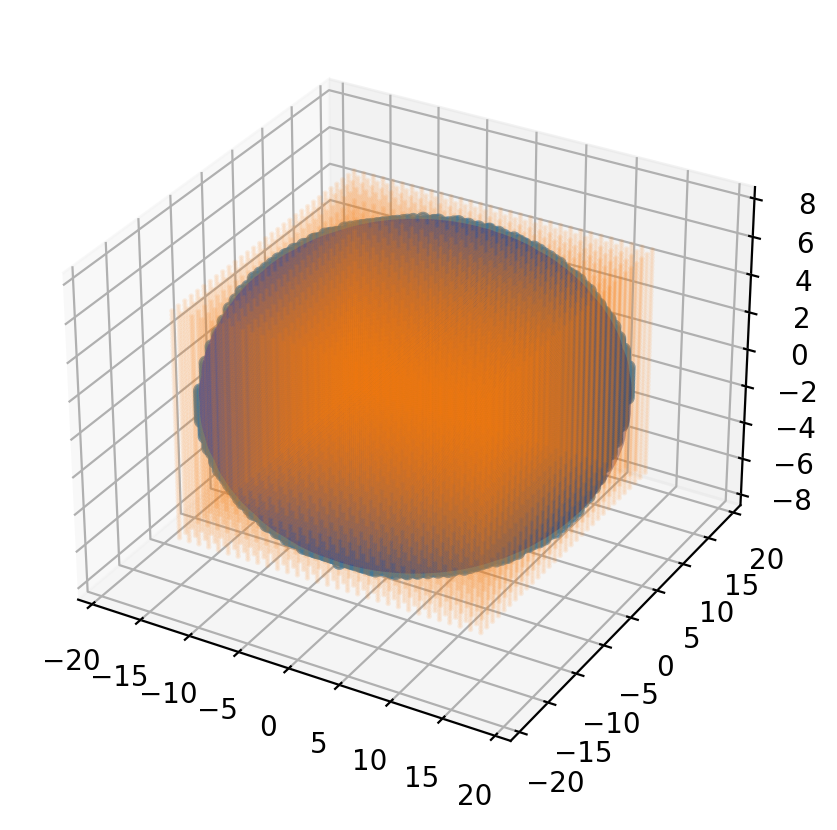

In [ ]:
(x0,x1) = (-0,0)
(y0,y1) = (-0,0)
(z0,z1) = (-6,6)
(Rx0,Rx1) = (-15,15)
(Ry0,Ry1) = (-15,15)
(Rz0,Rz1) = (-0,0)

(xR,yR,zR,RxR,RyR,RzR) = ((x1-x0)/2,(y1-y0)/2,(z1-z0)/2,(Rx1-Rx0)/2,(Ry1-Ry0)/2,(Rz1-Rz0)/2)

res = (0.2,1)

cubic_points = np.mgrid[
    x0:x1:(int((x1-x0)/res[0])+1)*1j,
    y0:y1:(int((y1-y0)/res[0])+1)*1j,
    z0:z1:(int((z1-z0)/res[0])+1)*1j,
    Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
    Ry0:Ry1:(int((Ry1-Ry0)/res[1])+1)*1j,
    Rz0:Rz1:(int((Rz1-Rz0)/res[1])+1)*1j].reshape(6,-1,order='F').T

print(cubic_points.shape)

# print(c_points_normed)

semi_axes_0 = np.ones(6) * 0.8
axes_radii = np.array((xR,yR,zR,RxR,RyR,RzR))
axes_radii[(axes_radii == 0)] = 1
print(axes_radii)

semi_axes = semi_axes_0 / axes_radii

# print(cubic_points[:,0])
radii = ((semi_axes[0]*cubic_points[:,0])**2 + 
        (semi_axes[1]*cubic_points[:,1])**2 + 
        (semi_axes[2]*cubic_points[:,2])**2 + 
        (semi_axes[3]*cubic_points[:,3])**2 + 
        (semi_axes[4]*cubic_points[:,4])**2 +
        (semi_axes[5]*cubic_points[:,5])**2)**0.5

# print(radii)

mask = radii <= 1
# print(mask)

# ellipsoid_points = cubic_points[np.where(mask)]
ellipsoid_points = cubic_points[mask]
print(ellipsoid_points.shape)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

ax.scatter(ellipsoid_points[:,3],ellipsoid_points[:,4],ellipsoid_points[:,2],c='C0',alpha=0.7)
ax.scatter(cubic_points[:,3],cubic_points[:,4],cubic_points[:,2],s=1,c='C1',alpha=0.1)


# coefs = (1/25, 1/25, 1/25)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
# Radii corresponding to the coefficients:
rx, ry, rz = RxR/0.8,RyR/0.8,zR/0.8

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', alpha= 0.2)

In [ ]:
# with np.printoptions(threshold=np.inf):
#     print(cubic_points)

cubic_points = np.mgrid[
    x0:x1:(int((x1-x0)/res[0])+1)*1j,
    y0:y1:(int((y1-y0)/res[0])+1)*1j,
    z0:z1:(int((z1-z0)/res[0])+1)*1j,
    Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
    Ry0:Ry1:(int((Ry1-Ry0)/res[1])+1)*1j,
    Rz0:Rz1:(int((Rz1-Rz0)/res[1])+1)*1j].reshape(6,-1,order='F').T


cubic_points.shape

(216, 6)

### Homework from Vanya
 - +/- 200 micrometers
 - +/- 10 degrees
 - +/- 1 mm by hand
 - +/- 3 mm total range of the image

